# Yelp Dataset: Trip Advisor Reviews

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams['figure.figsize'] = (10,7)
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['lines.markersize'] = 15
import numpy as np


import json
from pprint import pprint

# Bash Preprocessing of Yelp Dataset

The original json file was cleaned using bash commands as 'sed' and 'awk'. In particular we removed all the information but text and stars. The final cleaned date can be found in:

* 'data/data_cleaned' for the full dataset (we used it on the Cluster)

* 'data/data_cleaned_head1000/' for a reduced version with the first 1000 items (used on my mac)

This almost halved the size of our dataset, allowing a faster reading.

Hera a scatch of the command used:

* First Cleaning on Text

  cat yelptest.json | sed -e 's/"text":/\'$'\n"text":/g' | sed 's/"type":/\'$'\n"type:/g' | sed '/^"type/d' | sed '/"votes"/d' | sed 's/"text": //' | sed -e 's/\\n//g' | tr -d , | tr -d \" | sed -e 's/^/ /' > newfile.file

* Select stars

    cat oldfile.file | sed -e 's/"stars":/\'$'\n"stars":/g' | sed 's/"date":/\'$'\n"date:/g'| sed '/^"date/d' | sed '/"votes"/d'| sed 's/"stars": //' | tr -d , > newfile.file

* Remove \n in text

    sed -e 's/\\n//g' oldfile.file > newfile.file

# Preliminar Analysis of the Reduced Version (1000 items)

In [2]:
%%time

# LOADING DATA (HEAD 1000)

features_data = open("data/data_cleaned_head1000/textfeatures_head1000", "r")
target_data = open("data/data_cleaned_head1000/starstarget_head1000", "r")

# LOADING DATA (FULL Dataset to use on Cluster)

#features_data = open("data/data_cleaned/textfeatures0", "r")
#target_data = open("data/data_cleaned/starstarget0", "r")

text = [line for line in features_data]
target = [int(line.split()[0]) for line in target_data]

#print text[0]
#print target[0]

CPU times: user 2.25 s, sys: 952 ms, total: 3.2 s
Wall time: 4.57 s


The target contains number from 1 to 5, according to the rating (stars). In order to classify the commment in "positive" (+1) or "negative" (0), we convey to choose positive if stars are grater or equal to 3 and negative elsewhere.



In [3]:
%%time 
# "1" = "positive"
# "0" = "negative"
target = [ 1 if target[i] >=3 else 0 for i in range(len(target ))]

# Let us form an array such that [[text_1, target_1],..., [text_n,target_n]]

dataset = [[text[i], target[i]] for i in range(len(target))]


CPU times: user 2.61 s, sys: 871 ms, total: 3.48 s
Wall time: 3.5 s


# Rebalancing the Classes

With a simple counting we realize that the two classes have completly different sizes. There are much more positive comments than negative ones. The ratio is about $1/3$

In [4]:
target_pos = target.count(1)
target_neg = target.count(0)
ratio = float(target_neg) / target_pos

print "Positive = %d, Negative = %d, Ratio = %f" %(target_pos, target_neg, ratio)


Positive = 820907, Negative = 192006, Ratio = 0.233895


In [5]:
import random

def rebalance(dataset_to_reb, length, ratio): 
    reb_dataset = []
    for i in range(length):
        if dataset_to_reb[i][1] == 0:
            reb_dataset.append(dataset_to_reb[i])
        else:
            rnd = random.random()
            if rnd < ratio:
                reb_dataset.append(dataset_to_reb[i])
    return reb_dataset

reb_dataset = rebalance(dataset, len(target), ratio)
#reb_dataset = np.array(reb_dataset)

reb_text = [ tx for [tx,tg] in reb_dataset]
reb_target = [ tg for [tx,tg] in reb_dataset]

assert len(reb_text) == len(reb_target), "Problem!"
    

Let's check that the balancing succedeed 

In [6]:

print "Positive = %d, Negative = %d, Ratio = %f" %(reb_target.count(1), reb_target.count(0), 
                                                   float(reb_target.count(0)) / reb_target.count(1))


Positive = 191488, Negative = 192006, Ratio = 1.002705


# From text to vectors

We first modify the default stop_words = 'english' by removing the word "not" and appending some other words we consider useless.

(very useful: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [7]:
# First selection of stop_words

default_stop_words = ['all', 'six', 'less', 'being', 'indeed', 'over', 'move', 'anyway', 'not', 'fifty', 'four', 'own', 'through', 'yourselves', 'go', 'where', 'mill', 'only', 'find', 'before', 'one', 'whose', 'system', 'how', 'somewhere', 'with', 'thick', 'show', 'had', 'enough', 'should', 'to', 'must', 'whom', 'seeming', 'under', 'ours', 'has', 'might', 'thereafter', 'latterly', 'do', 'them', 'his', 'around', 'than', 'get', 'very', 'de', 'none', 'cannot', 'every', 'whether', 'they', 'front', 'during', 'thus', 'now', 'him', 'nor', 'name', 'several', 'hereafter', 'always', 'who', 'cry', 'whither', 'this', 'someone', 'either', 'each', 'become', 'thereupon', 'sometime', 'side', 'two', 'therein', 'twelve', 'because', 'often', 'ten', 'our', 'eg', 'some', 'back', 'up', 'namely', 'towards', 'are', 'further', 'beyond', 'ourselves', 'yet', 'out', 'even', 'will', 'what', 'still', 'for', 'bottom', 'mine', 'since', 'please', 'forty', 'per', 'its', 'everything', 'behind', 'un', 'above', 'between', 'it', 'neither', 'seemed', 'ever', 'across', 'she', 'somehow', 'be', 'we', 'full', 'never', 'sixty', 'however', 'here', 'otherwise', 'were', 'whereupon', 'nowhere', 'although', 'found', 'alone', 're', 'along', 'fifteen', 'by', 'both', 'about', 'last', 'would', 'anything', 'via', 'many', 'could', 'thence', 'put', 'against', 'keep', 'etc', 'amount', 'became', 'ltd', 'hence', 'onto', 'or', 'con', 'among', 'already', 'co', 'afterwards', 'formerly', 'within', 'seems', 'into', 'others', 'while', 'whatever', 'except', 'down', 'hers', 'everyone', 'done', 'least', 'another', 'whoever', 'moreover', 'couldnt', 'throughout', 'anyhow', 'yourself', 'three', 'from', 'her', 'few', 'together', 'top', 'there', 'due', 'been', 'next', 'anyone', 'eleven', 'much', 'call', 'therefore', 'interest', 'then', 'thru', 'themselves', 'hundred', 'was', 'sincere', 'empty', 'more', 'himself', 'elsewhere', 'mostly', 'on', 'fire', 'am', 'becoming', 'hereby', 'amongst', 'else', 'part', 'everywhere', 'too', 'herself', 'former', 'those', 'he', 'me', 'myself', 'made', 'twenty', 'these', 'bill', 'cant', 'us', 'until', 'besides', 'nevertheless', 'below', 'anywhere', 'nine', 'can', 'of', 'your', 'toward', 'my', 'something', 'and', 'whereafter', 'whenever', 'give', 'almost', 'wherever', 'is', 'describe', 'beforehand', 'herein', 'an', 'as', 'itself', 'at', 'have', 'in', 'seem', 'whence', 'ie', 'any', 'fill', 'again', 'hasnt', 'inc', 'thereby', 'thin', 'no', 'perhaps', 'latter', 'meanwhile', 'when', 'detail', 'same', 'wherein', 'beside', 'also', 'that', 'other', 'take', 'which', 'becomes', 'you', 'if', 'nobody', 'see', 'though', 'may', 'after', 'upon', 'most', 'hereupon', 'eight', 'but', 'serious', 'nothing', 'such', 'why', 'a', 'off', 'whereby', 'third', 'i', 'whole', 'noone', 'sometimes', 'well', 'amoungst', 'yours', 'their', 'rather', 'without', 'so', 'five', 'the', 'first', 'whereas', 'once']
list_word_to_remove = ['not']
my_stop_words = [word for word in default_stop_words if word not in list_word_to_remove]

# adding some other stop words to my_stop_words

my_stop_words.append('ve') 
my_stop_words.append('ll')
my_stop_words.append('got')
my_stop_words.append('know')
my_stop_words.append('15')
my_stop_words.append('30')
my_stop_words.append('20')
my_stop_words.append('50')

print len(my_stop_words)

325


Now we slpit our balanced dataset in Training and Test parts.

In [8]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reb_text, reb_target, test_size=0.2, random_state=42)

/Users/Yak52/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### My selected words

The idea of this section is to build our own stop_words set.

The following function counts for each word how many times it appear in positive documents or negative documents
and then it takes into account that if a word appears almost equally in both, then is not so important 
for the calssification of the document.

To understand what the threshold is, the following example is useful. Suppose the word XXX appears in 100 documents, where 99 of them are positive just 1 is negative. Then we say that its thrs is 0.99. The word XXX appears almost in every postive documents among the ones it appears. Words with thresholds 0.5 are words that equally appear in positive and negative documents. They are less significant in order to determine the class of the document. 

In [9]:
%%time 

from sklearn.feature_extraction.text import CountVectorizer

def selected_stop_words(old_stop_words, thres):
    new_stop_words = list(old_stop_words)
    
    # Count Vectorizer Section
    cv = CountVectorizer(stop_words = old_stop_words, max_df = 0.9, min_df = 10)
    train_cv = cv.fit_transform(X_train)
    total_word_count = train_cv.sum(axis = 0)

    # In how many docs the word appears?
    word_in_all_docs = np.array(train_cv.sign().sum(axis=0))
    
    # In how many positive docs the word appears?
    word_in_pos_docs = train_cv.sign().transpose().dot(y_train)
    word_pos_ratio = word_in_pos_docs.astype(float) / word_in_all_docs

    twc = total_word_count.shape[1]
    for w in range(twc):
        if word_pos_ratio[0,w] < thres and word_pos_ratio[0,w] > (1.0 - thres):
            word = cv.get_feature_names()[w]
            new_stop_words.append(word)
    np.savetxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, new_stop_words, fmt="%s")
    return new_stop_words 

def word_pos_ratio():

    # In how many docs the word appears?
    word_in_all_docs = np.array(train_cv.sign().sum(axis=0))
    
    # In how many positive docs the word appears?
    word_in_pos_docs = train_cv.sign().transpose().dot(y_train)
    ret = word_in_pos_docs.astype(float) / word_in_all_docs
    return ret

#my_stop_words_refined = selected_stop_words(my_stop_words, 0.7)
#selected_stop_words(my_stop_words, 0.55)

CPU times: user 2.4 ms, sys: 3.07 ms, total: 5.47 ms
Wall time: 14.3 ms


#### Looking at the number of stop words while increasing the threshold

In [10]:
thr_list = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
for thres in thr_list:
    nsw = np.loadtxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, dtype=str)
    print "if %.2f, Number of Stop Words: %d" %(thres, len(nsw)) 

if 0.50, Number of Stop Words: 325
if 0.55, Number of Stop Words: 6574
if 0.60, Number of Stop Words: 11832
if 0.70, Number of Stop Words: 21472
if 0.80, Number of Stop Words: 27619
if 0.90, Number of Stop Words: 30459
if 0.95, Number of Stop Words: 31162


In [27]:

# max_df = When building the vocabulary ignore terms that have a document 
#          frequency strictly higher than the given threshold (corpus-specific stop words).

# min_df = When building the vocabulary ignore terms that have a document 
#          frequency strictly lower than the given threshold. This value is also called cut-off in the literature.

from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(stop_words = my_stop_words)

#---------------------------------------------------------------------------
# Removing words which are appearing in all documents
# or appearing only in very few documents

#Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(stop_words = my_stop_words, max_df = 0.9, min_df = 10)
#---------------------------------------------------------------------------

#Learn the vocabulary dictionary and return term-document matrix.
train_cv = cv.fit_transform(X_train)

print train_cv.shape
print len(cv.vocabulary_)

total_word_count = train_cv.sum(axis = 0)
print total_word_count.shape

cv_top_50_words_position = {}


print "Most frequent words:"
for idx in xrange(1,51):
    vocabulary_index = total_word_count.argsort(axis=1)[0,-1*idx]
    word = cv.get_feature_names()[vocabulary_index]
    print "{0:10} {1:10} {2:10}".format(idx,word,total_word_count[0,vocabulary_index])
    cv_top_50_words_position[word]=idx

# By removing the english stopwords some words in the top
# 20 starts to be significant to classify the 2 categories
# we are considering.
# But the total number of feature is still huge (7323)

(357, 346)
346
(1, 346)
Most frequent words:
         1 not               305
         2 food              219
         3 good              179
         4 place             164
         5 like              153
         6 time              133
         7 just              129
         8 service           124
         9 great             103
        10 don                84
        11 breakfast          72
        12 order              71
        13 really             70
        14 nice               67
        15 ordered            65
        16 went               64
        17 night              62
        18 came               61
        19 staff              59
        20 said               58
        21 did                58
        22 cheese             57
        23 people             57
        24 better             56
        25 think              56
        26 way                56
        27 bar                55
        28 minutes            54
        29 fish               5

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(stop_words = my_stop_words)

#---------------------------------------------------------------------------
# Removing words which are appearing in all documents
# or appearing only in very few documents
cv = CountVectorizer(stop_words = my_stop_words_refined, max_df = 0.9, min_df = 10)
#---------------------------------------------------------------------------

train_cv = cv.fit_transform(X_train)

print train_cv.shape
print len(cv.vocabulary_)

total_word_count = train_cv.sum(axis = 0)
print total_word_count.shape

cv_top_50_words_position = {}


print "Most frequent words:"
for idx in xrange(1,51):
    vocabulary_index = total_word_count.argsort(axis=1)[0,-1*idx]
    word = cv.get_feature_names()[vocabulary_index]
    print "{0:10} {1:10} {2:10} {3:10}".format(idx,word,total_word_count[0,vocabulary_index], 
                                               word_pos_ratio()[0,vocabulary_index] )
    cv_top_50_words_position[word]=idx

(357, 94)
94
(1, 94)
Most frequent words:
         1 great             103 0.752941176471
         2 order              71       0.18
         3 ordered            65 0.214285714286
         4 said               58 0.153846153846
         5 minutes            54 0.105263157895
         6 friendly           53 0.833333333333
         7 told               44 0.205882352941
         8 room               43 0.291666666667
         9 customer           41 0.0357142857143
        10 store              40 0.291666666667
        11 10                 39 0.181818181818
        12 asked              38 0.258064516129
        13 didn               36 0.290322580645
        14 ok                 34 0.285714285714
        15 delicious          33 0.857142857143
        16 business           31 0.291666666667
        17 chinese            31 0.285714285714
        18 wait               31 0.142857142857
        19 definitely         29       0.76
        20 help               26 0.272727272727
     

## The TF-IDF transformation

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

train_tfidf = tfidf.fit_transform(train_cv)
print train_tfidf.shape

total_word_tfidf = train_tfidf.sum(axis = 0)
print total_word_tfidf.shape


print "Most frequent words:"
for idx in xrange(1,51):
    vocabulary_index = total_word_tfidf.argsort(axis=1)[0,-1*idx]
    word = cv.get_feature_names()[vocabulary_index]
    old_position = '-'
    if word in cv_top_50_words_position:
        old_position=str(cv_top_50_words_position[word])
    print "{0:10} {1:10} {2:10.2f} {3:10} {4:10}".format(idx,word,total_word_tfidf[0,vocabulary_index],old_position, 
                                                  word_pos_ratio()[0,vocabulary_index])

(357, 94)
(1, 94)
Most frequent words:
         1 great           31.81 1          0.752941176471
         2 friendly        23.14 6          0.833333333333
         3 order           16.47 2                0.18
         4 delicious       13.93 15         0.857142857143
         5 ordered         13.85 3          0.214285714286
         6 store           13.02 10         0.291666666667
         7 minutes         12.48 5          0.105263157895
         8 10              12.02 11         0.181818181818
         9 chinese         11.59 17         0.285714285714
        10 said            11.55 4          0.153846153846
        11 room            11.14 8          0.291666666667
        12 didn            10.95 13         0.290322580645
        13 customer        10.58 9          0.0357142857143
        14 told            10.25 7          0.205882352941
        15 definitely      10.22 19               0.76
        16 ok               9.86 14         0.285714285714
        17 wait         

# Decision Tree Classifier

In [31]:
%%time

# Training
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', 
                            splitter='best', 
                            max_depth=25, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=1, 
                            max_leaf_nodes=None, 
                            min_impurity_split=1e-07, 
                            class_weight=None, 
                            presort=False)

dt.fit(train_tfidf,y_train)

score_train = dt.score(train_tfidf,y_train)
print "The accuracy of the model on the training set is:",score_train

The accuracy of the model on the training set is: 0.924369747899
CPU times: user 25.4 ms, sys: 25 ms, total: 50.4 ms
Wall time: 86.8 ms


In [14]:
%%time

# test
test_cv = cv.transform(X_test)
test_tfidf = tfidf.transform(test_cv)

score_test = dt.score(test_tfidf,y_test)
print "The accuracy of the model on the training set is:",score_test

The accuracy of the model on the training set is: 0.703296703297
CPU times: user 28.2 ms, sys: 6.32 ms, total: 34.5 ms
Wall time: 30.5 ms


### Industrialize your model: Pipeline 

In [11]:
%%time 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn import pipeline



# Pipeline for Decision Tree
def my_pipeline_dt(thres):
    nsw = np.loadtxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, dtype=str)
    pipe = pipeline.Pipeline([
                            ('count_vectorizer', CountVectorizer(stop_words = list(nsw), max_df = 0.9, min_df = 10)),
                            #('count_vectorizer', CountVectorizer(stop_words = my_stop_words, max_df = 0.9, min_df = 10)),
                            ('tf_idf',TfidfTransformer()),
                            ('model',DecisionTreeClassifier(criterion='gini', 
                                                            splitter='best', 
                                                            max_depth=10, 
                                                            min_samples_split=2, 
                                                            min_samples_leaf=1, 
                                                            min_weight_fraction_leaf=0.0, 
                                                            max_features=None, 
                                                            random_state=1, 
                                                            max_leaf_nodes=None, 
                                                            min_impurity_split=1e-07, 
                                                            class_weight=None, 
                                                            presort=False))
                         ])
    return pipe


CPU times: user 69.8 ms, sys: 34.3 ms, total: 104 ms
Wall time: 131 ms


In [19]:
%%time
#pipe = pipe.fit(X_train, y_train)
thr_list = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
scores = []
print "thr \t train_score \t test_score \n"
for thr in thr_list:
    mypipe = my_pipeline_dt(thr).fit(X_train, y_train)

    score_train_pipe = mypipe.score(X_train, y_train)
    score_test_pipe = mypipe.score(X_test, y_test)
    scores.append([thr, score_train_pipe, score_test_pipe])
    print "%f \t %f \t %f \t" %(thr, score_train_pipe, score_test_pipe)
# Uncomment if you need to generate new data
# np.savetxt("data/scores/dt_scores.txt", scores, fmt='%.5f')

thr 	 train_score 	 test_score 

0.500000 	 0.751339 	 0.742831 	
0.550000 	 0.732545 	 0.724432 	
0.600000 	 0.741738 	 0.732596 	
0.700000 	 0.734316 	 0.727414 	
0.800000 	 0.672286 	 0.670209 	
0.900000 	 0.641345 	 0.643566 	
0.950000 	 0.523835 	 0.524924 	
CPU times: user 15min, sys: 24.4 s, total: 15min 24s
Wall time: 15min 41s


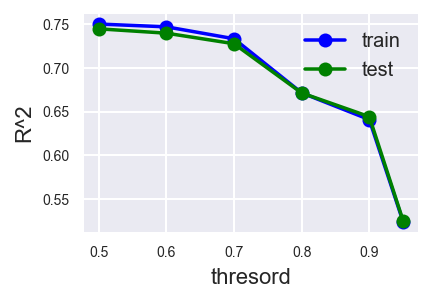

In [40]:
data = np.loadtxt("data/scores/dt_scores.txt")

thres = data[:,0]
train_score = data[:,1]
test_score = data[:,2]

matplotlib.rcParams['figure.figsize'] = (3,2)
matplotlib.rcParams['xtick.labelsize'] = 7
matplotlib.rcParams['ytick.labelsize'] = 7
matplotlib.rcParams['lines.markersize'] = 7
plt.plot(thres, train_score, "-o", color = "blue", label = "train")
plt.plot(thres, test_score, "-o", color = "green", label = "test")
plt.xlabel("thresord")
plt.ylabel("R^2")
plt.legend()
plt.show()

# Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [13]:
%%time

from sklearn.ensemble import RandomForestClassifier

rndforest = RandomForestClassifier(n_estimators=20, 
                       criterion='gini',
                       max_depth=3, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, 
                       max_features='auto', 
                       max_leaf_nodes=None, 
                       min_impurity_split=1e-07, 
                       bootstrap=True, 
                       oob_score=False, 
                       n_jobs=1, 
                       random_state=None, 
                       verbose=0, 
                       warm_start=False, 
                       class_weight=None)

#rndforest.fit(train_tfidf,y_train)

#score_train = rndforest.score(train_tfidf,y_train)
#print "The accuracy of the model on the training set is:",score_train

CPU times: user 67 µs, sys: 3 µs, total: 70 µs
Wall time: 77 µs


In [20]:
%%time

# test
test_cv = cv.transform(X_test)
test_tfidf = tfidf.transform(test_cv)

score_test = rndforest.score(test_tfidf,y_test)
print "The accuracy of the model on the training set is:",score_test

The accuracy of the model on the training set is: 0.714285714286
CPU times: user 46 ms, sys: 7.17 ms, total: 53.1 ms
Wall time: 49.6 ms


### Industrialize your model: Pipeline 

In [14]:
%%time 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn import pipeline


def my_pipeline_rf(thres):
    nsw = np.loadtxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, dtype=str)
    pipe = pipeline.Pipeline([
                            ('count_vectorizer', CountVectorizer(stop_words = list(nsw), max_df = 0.9, min_df = 10)),
                            #('count_vectorizer', CountVectorizer(stop_words = my_stop_words, max_df = 0.9, min_df = 10)),
                            ('tf_idf',TfidfTransformer()),
                            ('model',RandomForestClassifier(n_estimators=200, 
                                                               criterion='gini',
                                                               max_depth=2, 
                                                               min_samples_split=2, 
                                                               min_samples_leaf=1, 
                                                               min_weight_fraction_leaf=0.0, 
                                                               max_features='auto', 
                                                               max_leaf_nodes=None, 
                                                               min_impurity_split=1e-07, 
                                                               bootstrap=True, 
                                                               oob_score=False, 
                                                               n_jobs=1, 
                                                               random_state=None, 
                                                               verbose=0, 
                                                               warm_start=False, 
                                                               class_weight=None))
                         ])
    return pipe

CPU times: user 37 µs, sys: 10 µs, total: 47 µs
Wall time: 42.9 µs


In [15]:
%%time
#pipe = pipe.fit(X_train, y_train)
thr_list = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
scores = []
print "thr \t train_score \t test_score \n"
for thr in thr_list:
    mypipe = my_pipeline_rf(thr).fit(X_train, y_train)

    score_train_pipe = mypipe.score(X_train, y_train)
    score_test_pipe = mypipe.score(X_test, y_test)
    scores.append([thr, score_train_pipe, score_test_pipe])
    print "%f \t %f \t %f \t" %(thr, score_train_pipe, score_test_pipe)
# Uncomment if you need to generate new data
# np.savetxt("data/scores/rf_scores.txt", scores, fmt='%.5f')

thr 	 train_score 	 test_score 

0.500000 	 0.745964 	 0.743334 	
0.550000 	 0.753066 	 0.750675 	
0.600000 	 0.763911 	 0.758954 	
0.700000 	 0.780440 	 0.777794 	
0.800000 	 0.766792 	 0.765747 	
0.900000 	 0.677782 	 0.675680 	
0.950000 	 0.537867 	 0.537725 	
CPU times: user 14min 53s, sys: 44.7 s, total: 15min 38s
Wall time: 15min 45s


# AdaBoost Classifier

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [16]:
from sklearn.ensemble import AdaBoostClassifier

def my_pipeline_AdaBoost(thres):
    nsw = np.loadtxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, dtype=str)
    pipe = pipeline.Pipeline([
                            ('count_vectorizer', CountVectorizer(stop_words = list(nsw), max_df = 0.9, min_df = 10)),
                            #('count_vectorizer', CountVectorizer(stop_words = my_stop_words, max_df = 0.9, min_df = 10)),
                            ('tf_idf',TfidfTransformer()),
                            ('model',AdaBoostClassifier(base_estimator=None, 
                                                           n_estimators=50, 
                                                           learning_rate=1.0, 
                                                           algorithm='SAMME.R', 
                                                           random_state=None))
                         ])
    return pipe

In [17]:
%%time
#pipe = pipe.fit(X_train, y_train)
thr_list = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
scores = []
print "thr \t train_score \t test_score \n"
for thr in thr_list:
    mypipe = my_pipeline_AdaBoost(thr).fit(X_train, y_train)

    score_train_pipe = mypipe.score(X_train, y_train)
    score_test_pipe = mypipe.score(X_test, y_test)
    scores.append([thr, score_train_pipe, score_test_pipe])
    print "%f \t %f \t %f \t" %(thr, score_train_pipe, score_test_pipe)
# Uncomment if you need to generate new data
# np.savetxt("data/scores/ab_scores.txt", scores, fmt='%.5f')

thr 	 train_score 	 test_score 

0.500000 	 0.806138 	 0.803596 	
0.550000 	 0.804664 	 0.802083 	
0.600000 	 0.804919 	 0.801731 	
0.700000 	 0.793840 	 0.793283 	
0.800000 	 0.756838 	 0.754769 	
0.900000 	 0.674470 	 0.672903 	
0.950000 	 0.534077 	 0.534205 	
CPU times: user 24min 42s, sys: 42.2 s, total: 25min 24s
Wall time: 25min 54s


# Linear Model: Logistic Regression



In [18]:
from sklearn.linear_model import LogisticRegression

def my_pipeline_logreg(thres):
    nsw = np.loadtxt("data/stop_words/my_stop_words_thr_%.2f.txt" %thres, dtype=str)
    pipe = pipeline.Pipeline([
                            ('count_vectorizer', CountVectorizer(stop_words = list(nsw), max_df = 0.9, min_df = 10)),
                            #('count_vectorizer', CountVectorizer(stop_words = my_stop_words, max_df = 0.9, min_df = 10)),
                            ('tf_idf',TfidfTransformer()),
                            ('model',LogisticRegression(penalty='l2', 
                                                           dual=False, 
                                                           tol=0.0001, 
                                                           C=1.0, 
                                                           fit_intercept=True, 
                                                           intercept_scaling=1, 
                                                           class_weight=None, 
                                                           random_state=None, 
                                                           solver='liblinear', 
                                                           max_iter=100,
                                                           multi_class='ovr',
                                                           verbose=0, 
                                                           warm_start=False, 
                                                           n_jobs=1))
                         ])
    return pipe

In [19]:
%%time
#pipe = pipe.fit(X_train, y_train)
thr_list = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
scores = []
print "thr \t train_score \t test_score \n"
for thr in thr_list:
    mypipe = my_pipeline_logreg(thr).fit(X_train, y_train)

    score_train_pipe = mypipe.score(X_train, y_train)
    score_test_pipe = mypipe.score(X_test, y_test)
    scores.append([thr, score_train_pipe, score_test_pipe])
    print "%f \t %f \t %f \t" %(thr, score_train_pipe, score_test_pipe)
# Uncomment if you need to generate new data
#np.savetxt("data/scores/lr_scores.txt", scores, fmt='%.5f')

thr 	 train_score 	 test_score 

0.500000 	 0.907394 	 0.893727 	
0.550000 	 0.902133 	 0.889281 	
0.600000 	 0.895546 	 0.883701 	
0.700000 	 0.870431 	 0.861993 	
0.800000 	 0.821448 	 0.815786 	
0.900000 	 0.701182 	 0.696580 	
0.950000 	 0.548053 	 0.542263 	
CPU times: user 13min 15s, sys: 30.5 s, total: 13min 45s
Wall time: 13min 39s


### Some Useful Plots

In [21]:
def mydata(name, score):
    ret = np.loadtxt("data/scores/%s_scores.txt" %name)
    if score == "thres":
        score = 0
    elif score == "train":
        score = 1
    else:
        score = 2
    return ret[:,score]

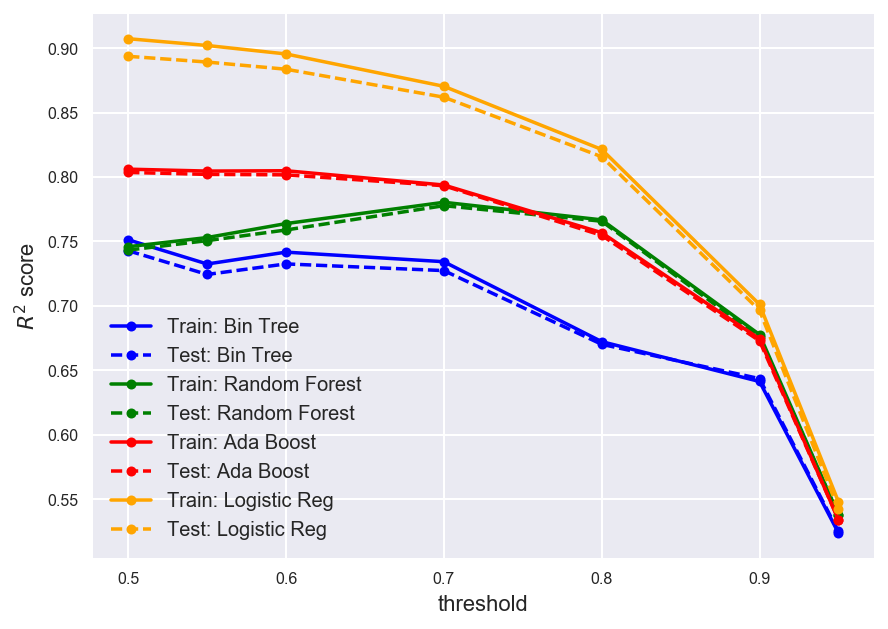

In [22]:

thres = mydata("dt", "thres")


matplotlib.rcParams['figure.figsize'] = (7,5)
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['lines.markersize'] = 5
plt.plot(thres, mydata("dt", "train"), "-o", color = "blue", label = "Train: Bin Tree")
plt.plot(thres, mydata("dt", "test"), "--o", color = "blue", label = "Test: Bin Tree")

plt.plot(thres, mydata("rf", "train"), "-o", color = "green", label = "Train: Random Forest")
plt.plot(thres, mydata("rf", "test"), "--o", color = "green", label = "Test: Random Forest")

plt.plot(thres, mydata("ab", "train"), "-o", color = "red", label = "Train: Ada Boost")
plt.plot(thres, mydata("ab", "test"), "--o", color = "red", label = "Test: Ada Boost")

plt.plot(thres, mydata("lr", "train"), "-o", color = "orange", label = "Train: Logistic Reg")
plt.plot(thres, mydata("lr", "test"), "--o", color = "orange", label = "Test: Logistic Reg")
plt.xlabel("threshold")
plt.ylabel(r"$R^2$ score")
plt.legend()
plt.show()

# Analysis of the Results

We can see that, among the different models we have used, the Logistic Regression seems to perform better that the others, also if there is a bit of overfitting (difference between train and test score). In particular it reaches the best performances when the threshold for my "selected_stop_words" is $0.5$, which means that the function is not used. 
Very good performances are also obtained using the AdaBoost model. In particular in this case overfitting seems to be removed.
The Random Forest implementation (in green), differently from Logistic Regression, seems to perform better when the threshold is around $0.7$. As expected when the threshold increases all the models have a drop in performances. The reason is that for instance with a threshold of $0.9$ we are stopping $31162$ words, dratically reducing the space of features.
Looking at the timing the Logistic Regression is also faster than than the others. 

# Next Step. Parameter Optimisation: Grid Search for Random Forest 

The Grid Search was runned on the Cluster. See below!

In [108]:
from sklearn.model_selection import GridSearchCV
from pandas import DataFrame

pipe = my_pipeline_rf(0.5)

gs = GridSearchCV(
                    pipe,
                    {
                        "count_vectorizer__min_df": range(1,10)+range(10,30,5),
                        "model__max_depth": range(1,20)+range(30,100,10)
                        #"count_vectorizer__min_df": range(1,3),
                        #"model__max_depth": [1, 2, 5]
                    },
                    cv=2,  # 5-fold cross validation
                    n_jobs=4,  # run each hyperparameter in one of two parallel jobs
                    scoring="accuracy" # what could happen selecting "precision" as scoring measure?
                )

#gs.fit(X_train, y_train)


# Parameter Optimisation: Grid Search for Logistic Regression 

The Grid Search was runned on the Cluster. See below!

In [109]:
from sklearn.model_selection import GridSearchCV

pipe = my_pipeline_logreg(0.5)

gs = GridSearchCV(
                    pipe,
                    {
                        "count_vectorizer__min_df": range(1,10)+range(10,30,5),
                        "model__C": [0.1, 0.5, 1.0, 3.0, 5.0, 10, 20, 50, 80]
                    },
                    cv=2,  # 5-fold cross validation
                    n_jobs=4,  # run each hyperparameter in one of two parallel jobs
                    scoring="accuracy" # what could happen selecting "precision" as scoring measure?
                )



#gs.fit(X_train, y_train)

# Loading Grid Results From Cluster Ulysses

For a more fast Grid Search, Ulysses cluster was used. First we converted our Jupiter notebook in a python script. This was done for Logistic Regression (since already from our laptop it is the model which achieves best performances) and also for Random Forest (just to try). The python script can be found in the folder "/pyscript".

In [25]:
import pickle 

with open('data/gridres/lr_grid_results.csv', 'rb') as fp:
    lr_res = pickle.load(fp)

with open('data/gridres/rf_grid_results.csv', 'rb') as fp:
    rf_res = pickle.load(fp)
    
with open('data/gridres/lr_grid_bestparameters.csv', 'rb') as fp:
    lr_bp = pickle.load(fp)
    
with open('data/gridres/rf_grid_bestparameters.csv', 'rb') as fp:
    rf_bp = pickle.load(fp)

In [102]:
from pandas import DataFrame

rf_res = DataFrame(data = rf_res)
lr_res = DataFrame(data = lr_res)
#results.head(10)

#### Random Forest: Grid of min_df 

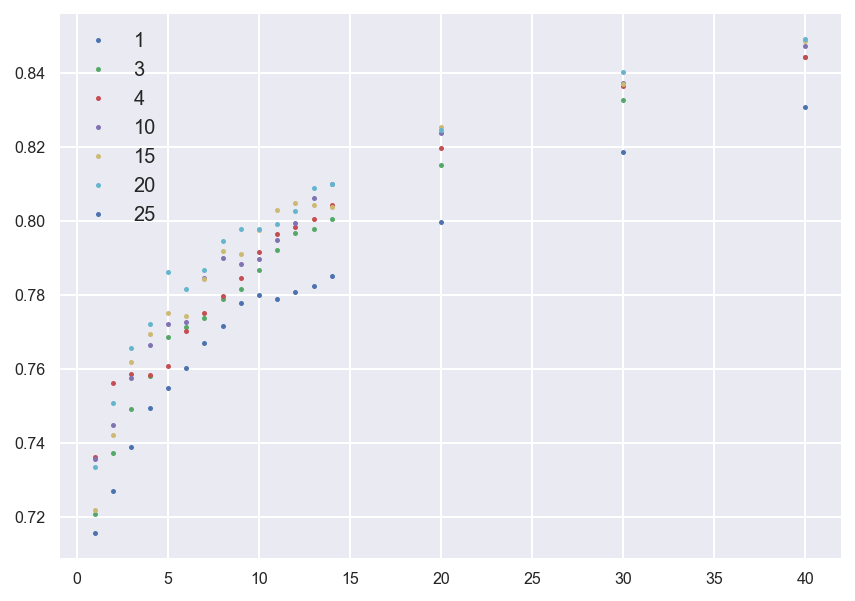

In [110]:
for idx,mdf in enumerate([1,3,4,10,15,20,25]):
    x = rf_res[rf_res['param_count_vectorizer__min_df']==mdf]['param_model__max_depth']
    y = rf_res[rf_res['param_count_vectorizer__min_df']==mdf]['mean_test_score']

    plt.plot(x,y,'.',label='{0}'.format(mdf))

plt.legend()

#### Random Forest: Grid of max_depth

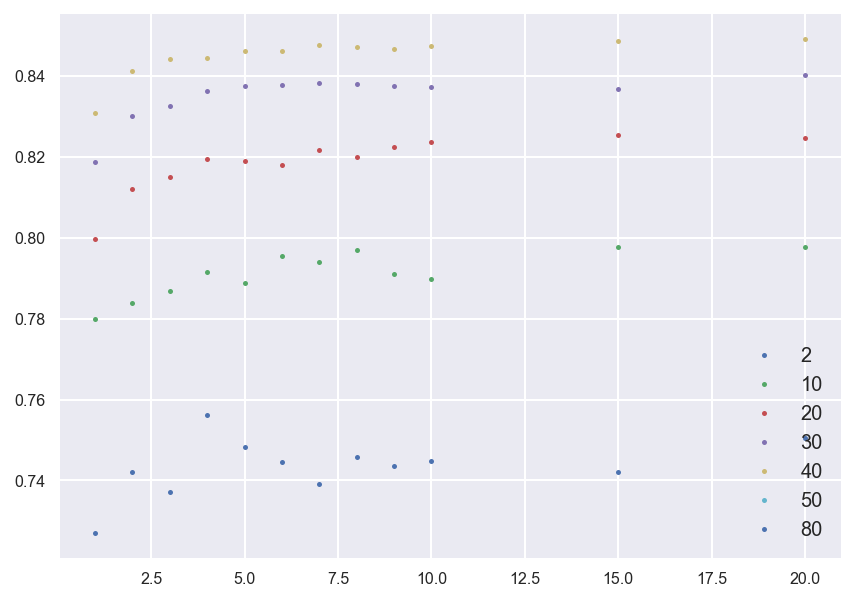

In [112]:
for idx,depth in enumerate([2,10,20,30,40,50,80]):
    x = rf_res[rf_res['param_model__max_depth']==depth]['param_count_vectorizer__min_df']
    y = rf_res[rf_res['param_model__max_depth']==depth]['mean_test_score']

    plt.plot(x,y,'.',label='{0}'.format(depth))

plt.legend()

#### Logistic Regression: Grid of min_df 

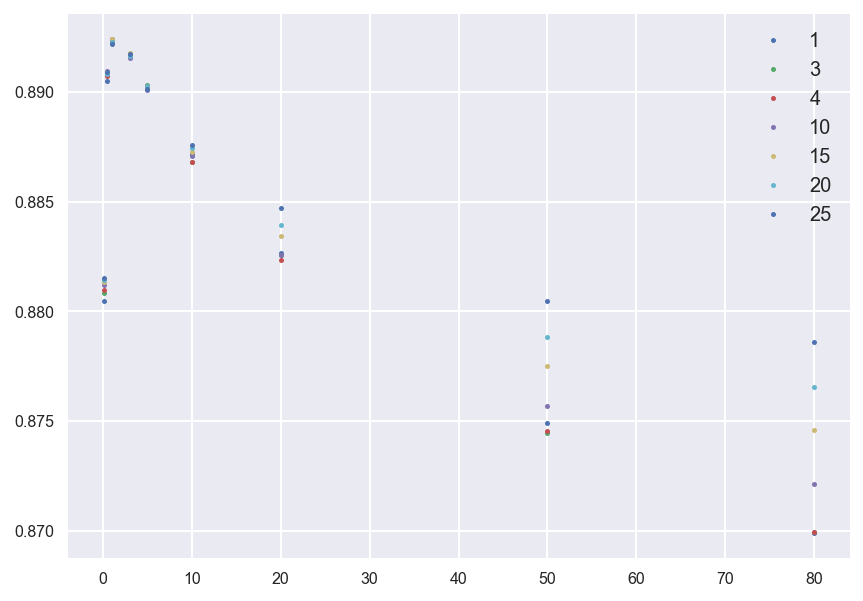

In [113]:
for idx,mdf in enumerate([1,3,4,10,15,20,25]):
    x = lr_res[lr_res['param_count_vectorizer__min_df']==mdf]['param_model__C']
    y = lr_res[lr_res['param_count_vectorizer__min_df']==mdf]['mean_test_score']

    plt.plot(x,y,'.',label='{0}'.format(mdf))

plt.legend()

#### Logistic Regression: Grid of param__C

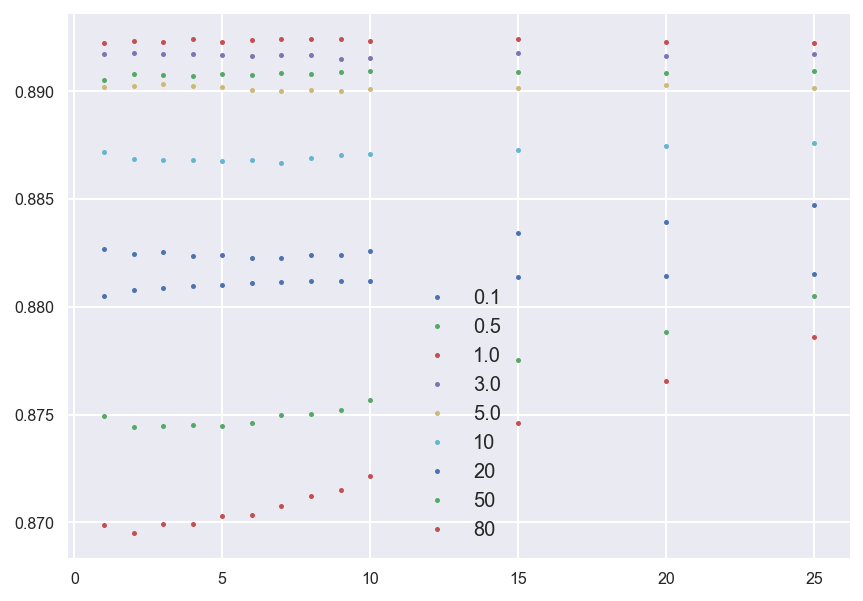

In [114]:
for idx,mdf in enumerate([0.1, 0.5, 1.0, 3.0, 5.0, 10, 20, 50, 80]):
    x = lr_res[lr_res['param_model__C']==mdf]['param_count_vectorizer__min_df']
    y = lr_res[lr_res['param_model__C']==mdf]['mean_test_score']

    plt.plot(x,y,'.',label='{0}'.format(mdf))

plt.legend()

#### Grid Search: Best Parameters

Therefore after running a Grid Search we are aware about the best parameters among the ones we choose to insert in the grid. In our case we found that:

In [26]:
print "Best Parameters for Random Forest ", rf_bp
print "Best Parameters for Logistic Regression ", lr_bp

Best Parameters for Random Forest  {'count_vectorizer__min_df': 20, 'model__max_depth': 40}
Best Parameters for Logistic Regression  {'model__C': 1.0, 'count_vectorizer__min_df': 15}


The Grid Search for the Random Forest allowed us to find a parameter setting such that the score increases up to $0.85$, while for the Logistic Regression the optimal solution is not different with the one we obtained with the initial parameter setting.